## INFO 5502 Assignment-8

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_precision_recall, plot_roc
import warnings
import seaborn as sn
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize']=[10,10]

In [67]:
df = pd.read_csv(r'data.csv')

In [68]:
print("Dataset shape: ", df.shape)

Dataset shape:  (569, 33)


Text(0, 0.5, 'Count of missing values')

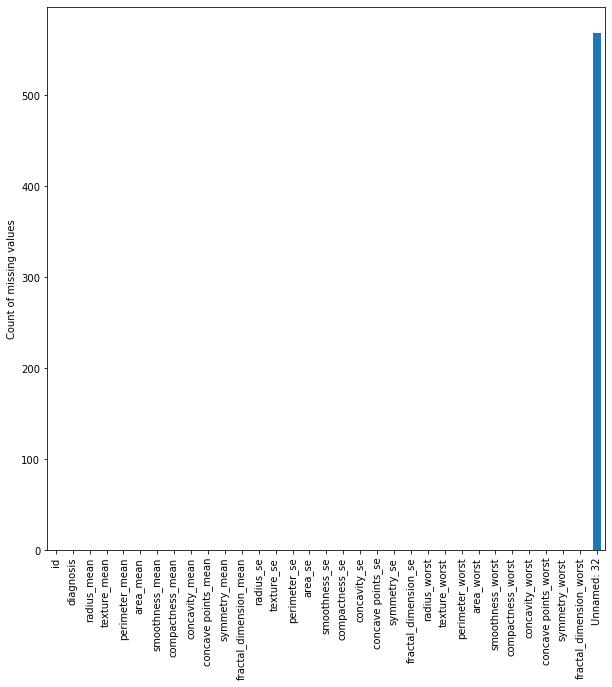

In [69]:
df.isnull().sum(axis=0).plot.bar()
plt.ylabel("Count of missing values")

In [70]:
df.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)

In [71]:
# statistics for all the columns
df.describe(include=['number', 'object'])

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080


In [72]:
label = LabelEncoder()
df['diagnosis'] = label.fit_transform(df['diagnosis'])

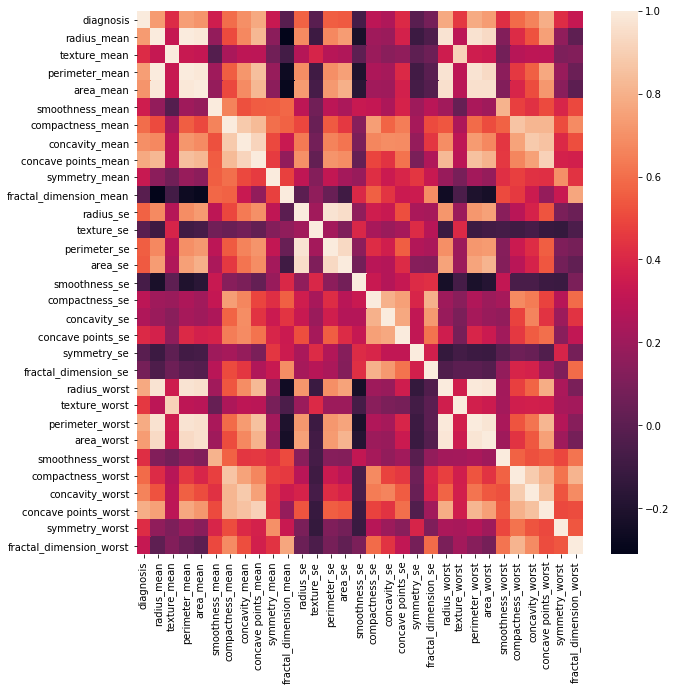

In [73]:
sn.heatmap(data=df.corr())

In [75]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [76]:
print(to_drop)

['perimeter_mean', 'area_mean', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']


In [77]:
df.drop(to_drop,axis=1, inplace=True)

Text(0.5, 0, 'Value (across all features)')

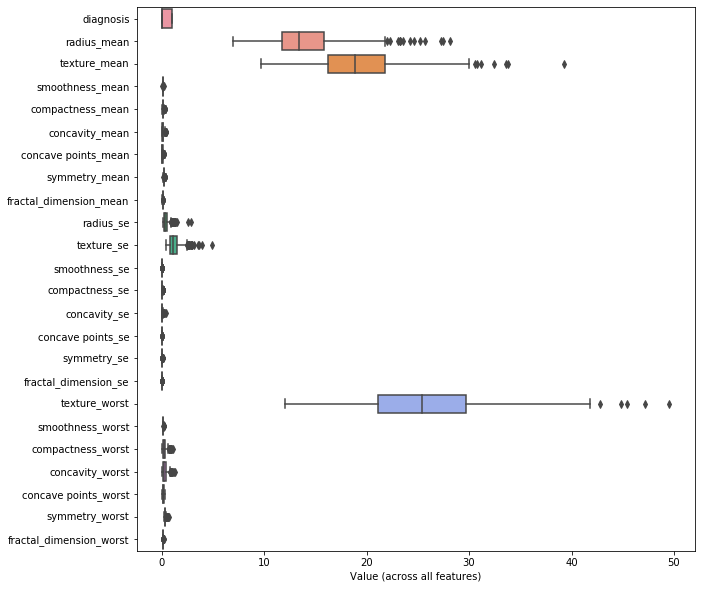

In [78]:
ax = sn.boxplot(data=df, orient='h')
ax.set_xlabel("Value (across all features)")

In [79]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'texture_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

0    357
1    212
Name: diagnosis, dtype: int64


Text(0, 0.5, 'Count of labels (target class)')

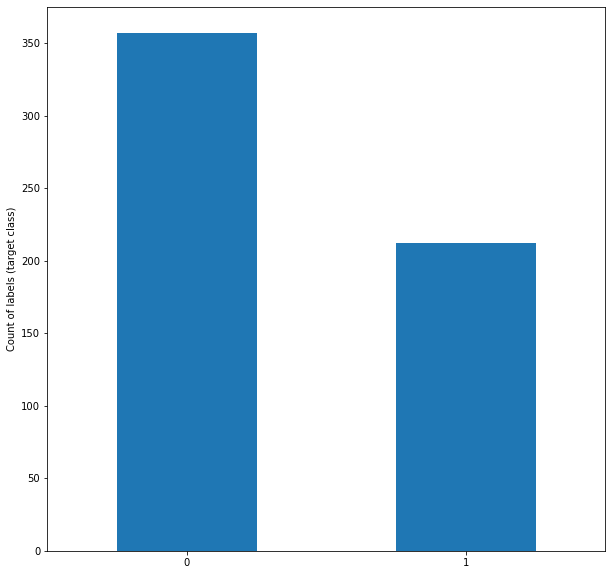

In [80]:
print(df['diagnosis'].value_counts())
df['diagnosis'].value_counts().plot.bar(rot=0)
plt.ylabel("Count of labels (target class)")


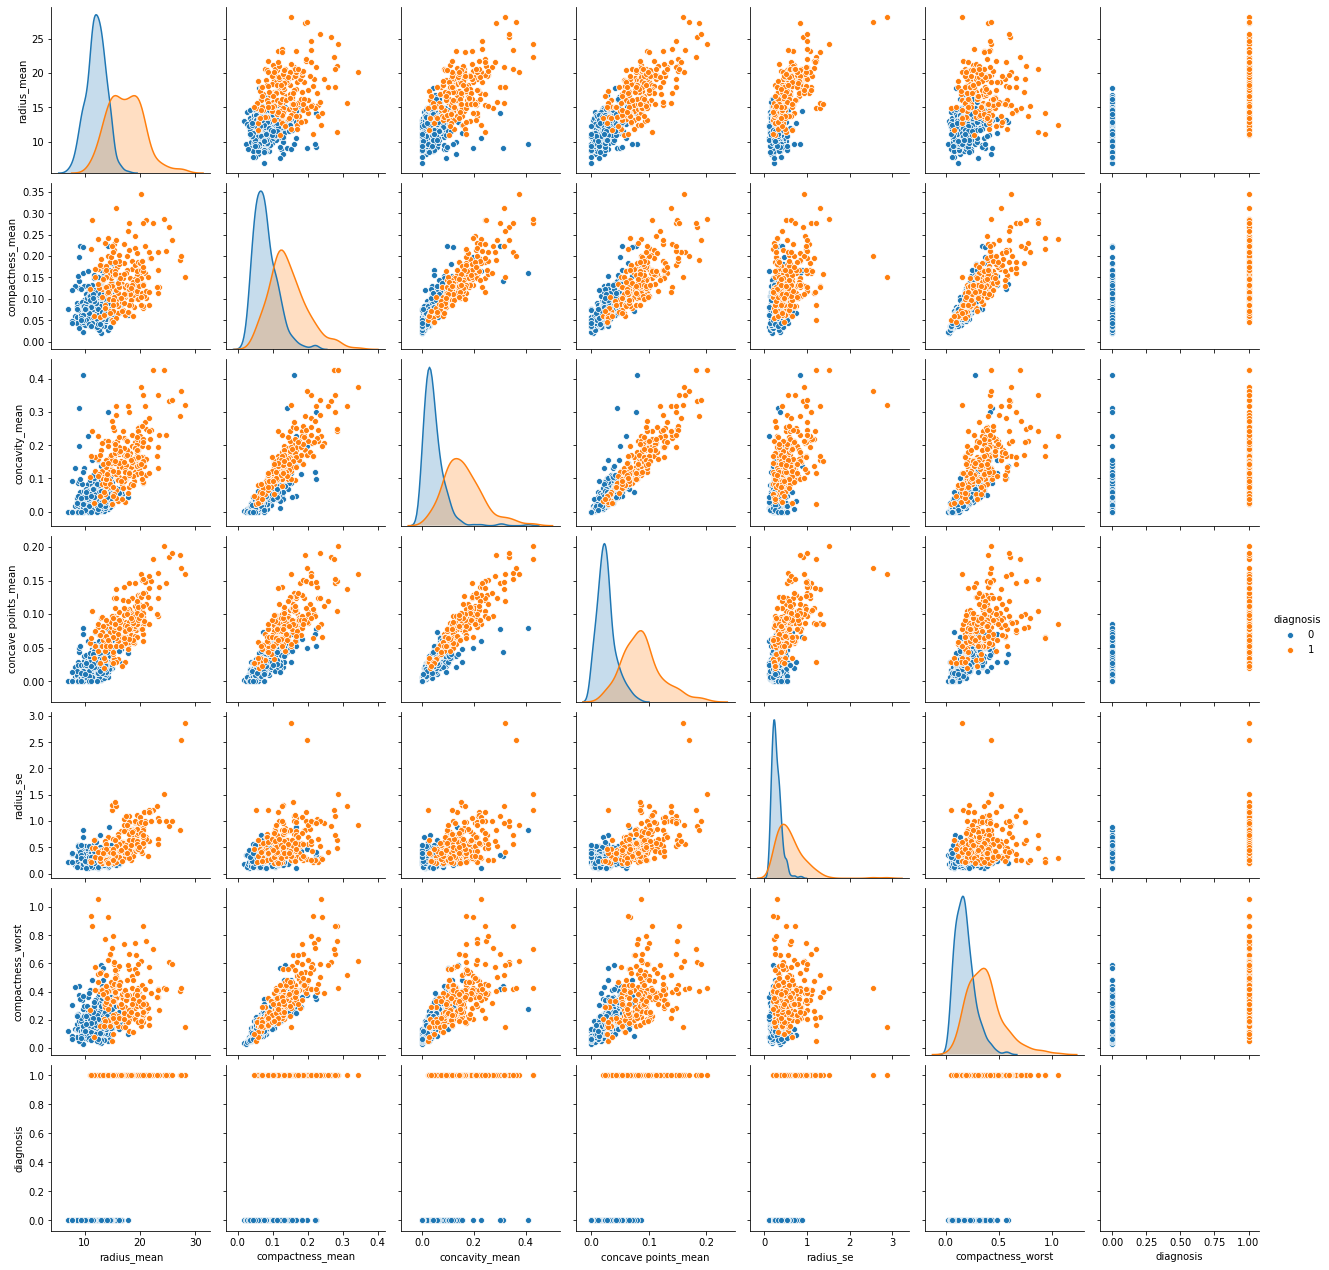

In [81]:
# Do bivariate analysis for highly correlated variables with 'diagnosis'
columns = ['radius_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'compactness_worst', 'diagnosis']
sn.pairplot(data=df[columns], hue='diagnosis',vars=['radius_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'compactness_worst', 'diagnosis'])

In [82]:
y = df['diagnosis']
X = df.loc[:, df.columns != 'diagnosis']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

In [83]:
scale = StandardScaler()

x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [84]:
n_neighbors = [3,5,7,9,11,13]
scores = []
for n in n_neighbors:
    model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    score =  cross_val_score(model, x_train, y_train, n_jobs=-1, cv=5, verbose=0)
    print("Number of neighbors: ", n)
    print("Cross validaiton score: ", score)
    print("Mean score: {} Standard Deviation {}".format(score.mean(), score.std()))
    scores.append(score.mean()) 

Number of neighbors:  3
Cross validaiton score:  [0.97802198 0.92307692 0.95604396 0.94505495 0.95604396]
Mean score: 0.9516483516483516 Standard Deviation 0.01785502946073835
Number of neighbors:  5
Cross validaiton score:  [0.97802198 0.94505495 0.94505495 0.93406593 0.96703297]
Mean score: 0.9538461538461538 Standard Deviation 0.016150481820548422
Number of neighbors:  7
Cross validaiton score:  [0.96703297 0.94505495 0.93406593 0.92307692 0.96703297]
Mean score: 0.9472527472527472 Standard Deviation 0.01758241758241757
Number of neighbors:  9
Cross validaiton score:  [0.96703297 0.93406593 0.95604396 0.93406593 0.96703297]
Mean score: 0.9516483516483516 Standard Deviation 0.014906219743132457
Number of neighbors:  11
Cross validaiton score:  [0.96703297 0.95604396 0.96703297 0.94505495 0.94505495]
Mean score: 0.956043956043956 Standard Deviation 0.009828870230768321
Number of neighbors:  13
Cross validaiton score:  [0.96703297 0.95604396 0.95604396 0.93406593 0.93406593]
Mean score

Text(0.5, 1.0, 'Mean Accuracy for different K values')

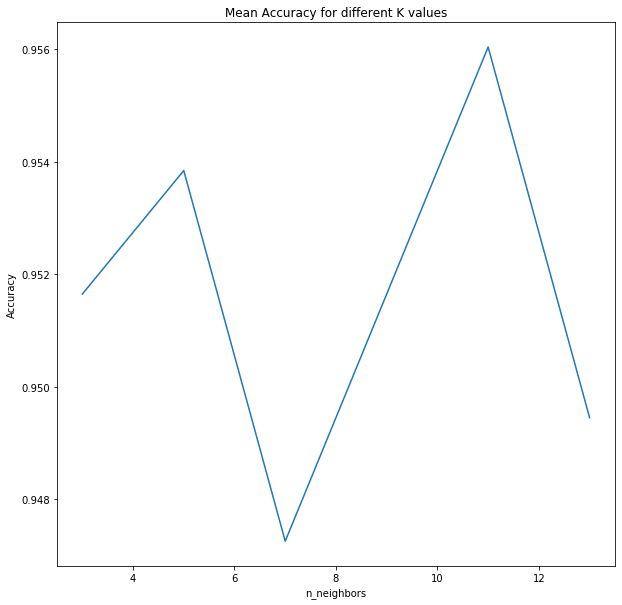

In [85]:
plt.plot(n_neighbors, scores)
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy for different K values")

In [86]:
max_index = scores.index(max(scores))
best_n = n_neighbors[max_index]
print("Best value of n: ", best_n)

Best value of n:  11


In [87]:
model = KNeighborsClassifier(n_neighbors=best_n, n_jobs=-1)

model.fit(x_train, y_train)

pred = model.predict(x_test)

In [88]:
print("Accuracy score: ", accuracy_score(y_test, pred))

Accuracy score:  0.956140350877193


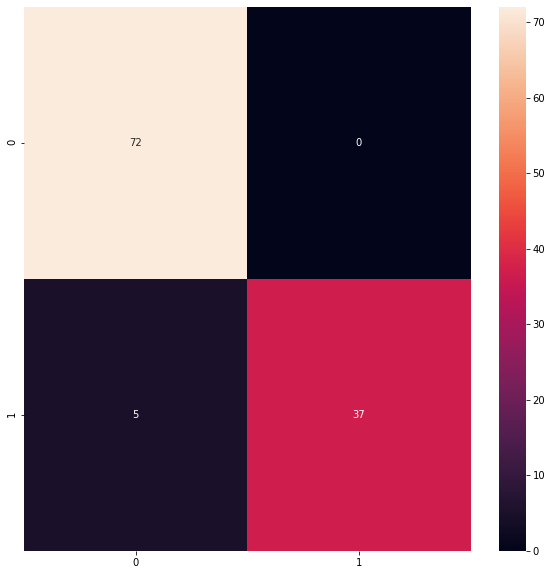

In [89]:
sn.heatmap(confusion_matrix(y_test, pred), annot=True)

In [90]:
pred_prob = model.predict_proba(x_test)


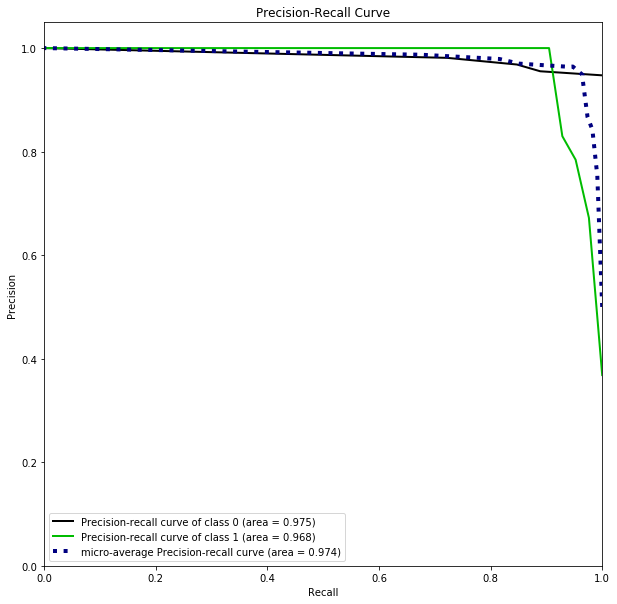

In [40]:
plot_precision_recall(y_test, pred_prob)

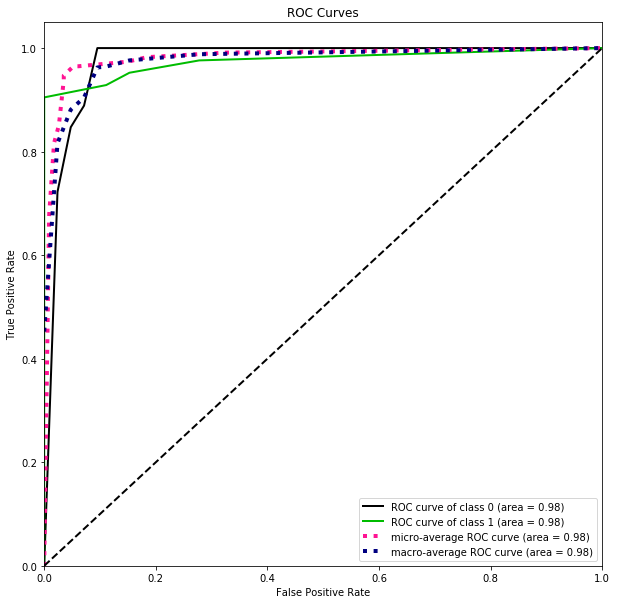

In [41]:
plot_roc(y_test, pred_prob)

Text(0.5, 1.0, 'Actual Classes')

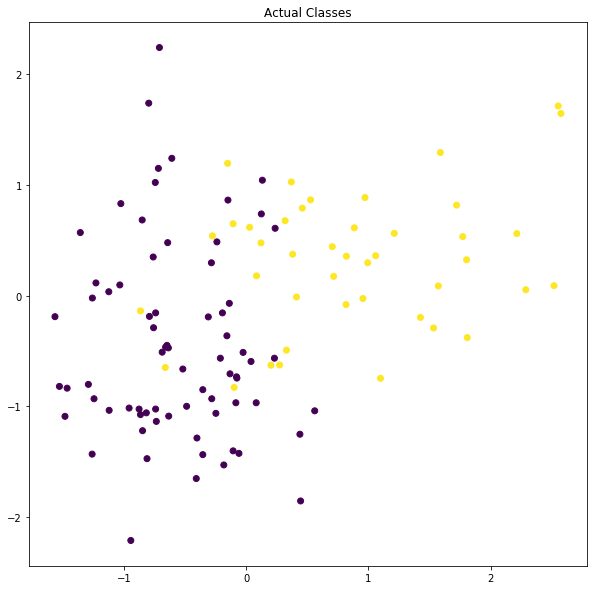

In [42]:
plt.scatter(x_test[:,0], x_test[:,1], c=y_test ,label=y_test)
plt.title("Actual Classes")

Text(0.5, 1.0, 'Predicted Classes')

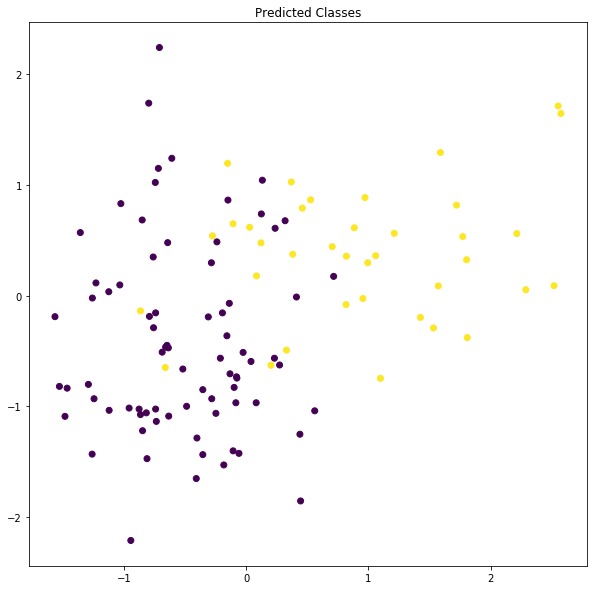

In [43]:
plt.scatter(x_test[:,0], x_test[:,1], c=pred ,label=pred)
plt.title("Predicted Classes")